# BIOS 26211 Final Project: Logistic Regression Predictive Model
Anushka Agrawal

In [88]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

In [89]:
data = pd.read_excel('final_project_clean_data.xlsx')
data = data.dropna()
data.sex = data.sex.replace(('M', 'F'), (0, 1))
data = data.drop("No", axis=1)
data.head()

,Waiting_time_for_KT,Primary_events,Primary_events_time,sex,age,Diabetes,Hypertension,Dyslipidemia,History_of_AMI,History_of_stroke,All_cause_death,All_cause_time,Nonfatal_AMI,Nonfatal_AMI_time,Nonfatal_stroke,Nonfatal_stroke_time,filter_$
0,3,0,2.761644,0,15,0,0,0,0,0,0,2.761644,0,2.761644,0,2.761644,0
1,1,0,6.608219,0,15,0,1,0,0,0,0,6.608219,0,6.608219,0,6.608219,1
2,1,0,5.380822,1,15,0,1,0,0,0,0,5.380822,0,5.380822,0,5.380822,1
3,1,0,2.030137,1,15,0,0,0,0,0,0,2.030137,0,2.030137,0,2.030137,1
4,1,0,12.715068,0,15,0,0,0,0,0,0,12.715068,0,12.715068,0,12.715068,1


# Data Exploration
Visualizing the data reveals that they are highly imbalanced with regards to outcomes of interest (primary events, all-cause death, nonfatal AMI, nonfatal stroke). Because of this, I elected to use the Synthetic Minority Oversampling Technique (SMOTE) to oversample the minority class in training sets. 

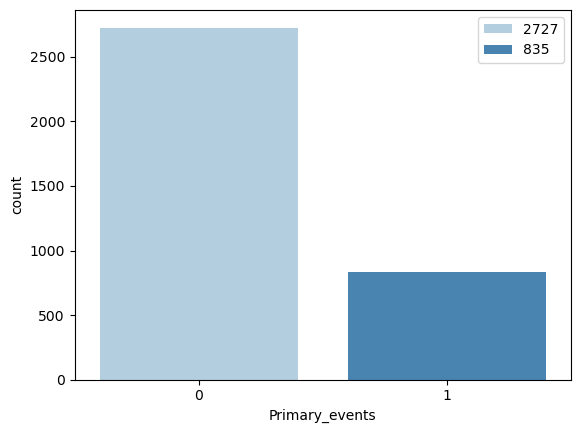

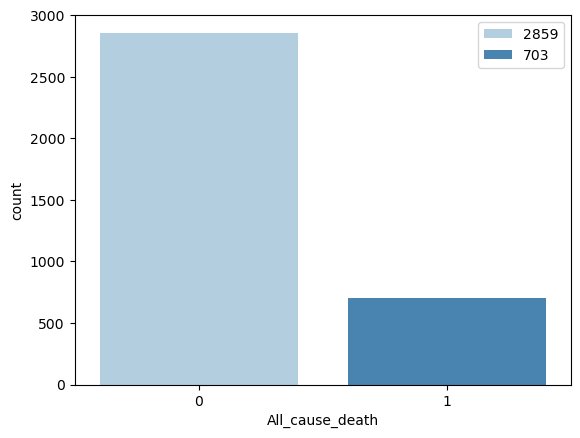

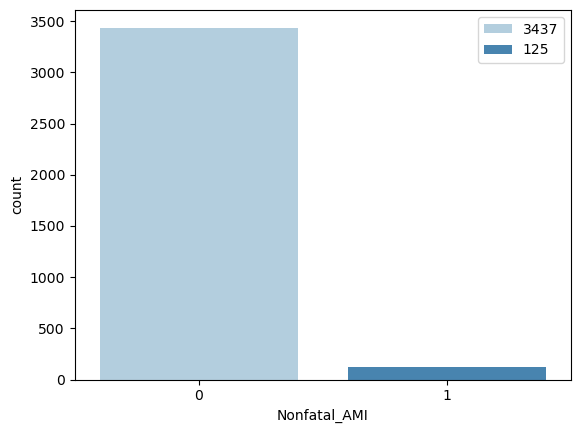

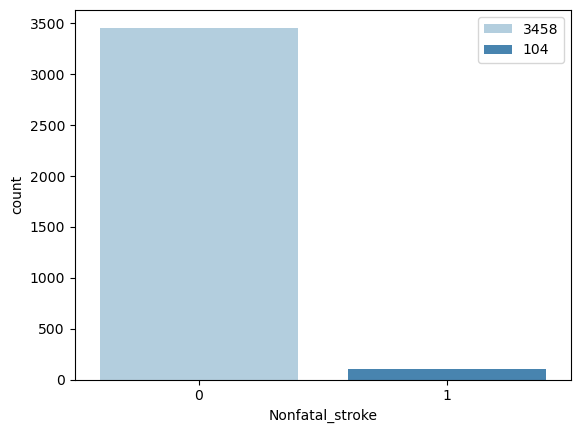

In [90]:
for outcome in ['Primary_events', 'All_cause_death', 'Nonfatal_AMI', 'Nonfatal_stroke']:
    sns.countplot(x=outcome, data=data, palette='Blues',
                  label=data[outcome].value_counts(ascending=False).values)
    
    plt.legend()
    plt.show()

# Logistic Regression Model using Stratified K-Fold Cross Validation (including KT Wait Time Feature)

outcome:  Primary_events
max accuracy:  0.6910112359550562
min accuracy:  0.5898876404494382
overall accuracy:  0.6266224467315016


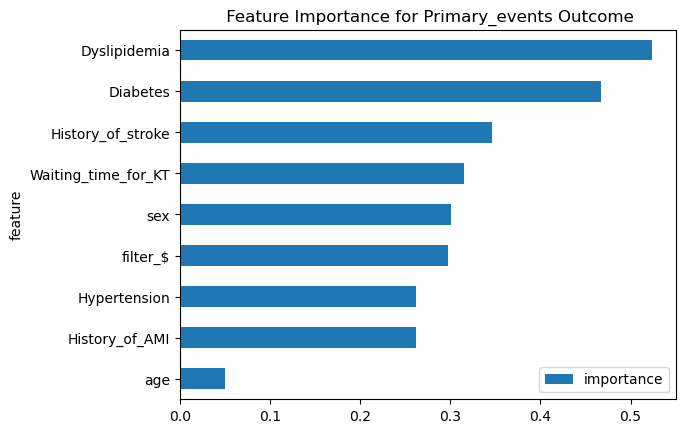

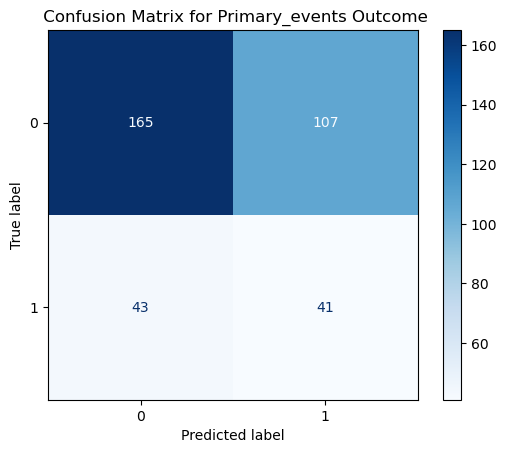

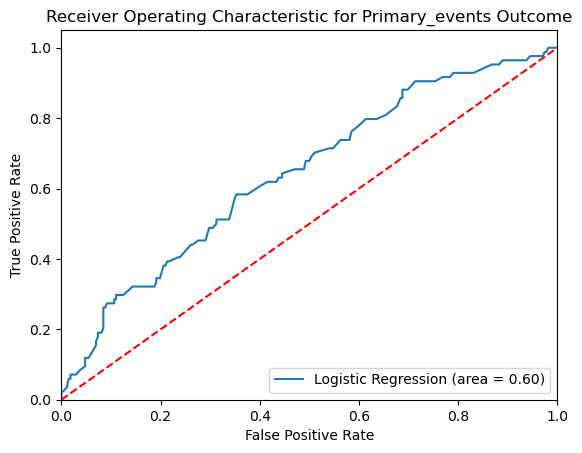

outcome:  All_cause_death
max accuracy:  0.6713483146067416
min accuracy:  0.6022408963585434
overall accuracy:  0.6339226701916723


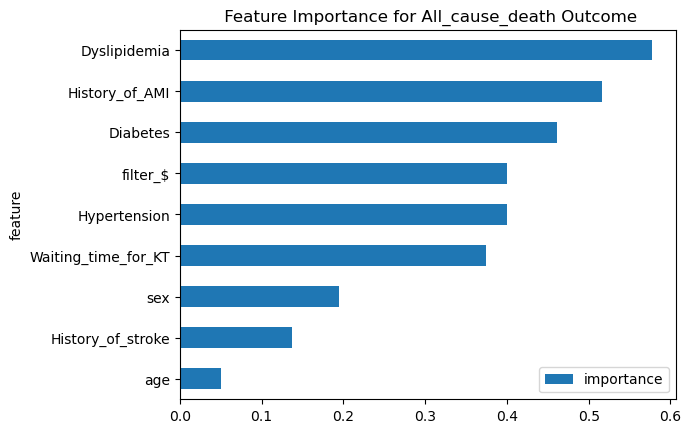

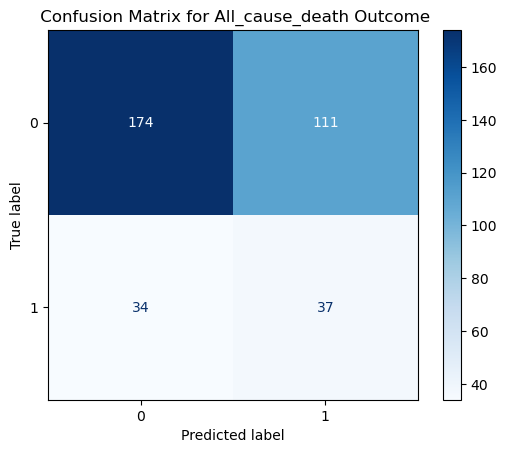

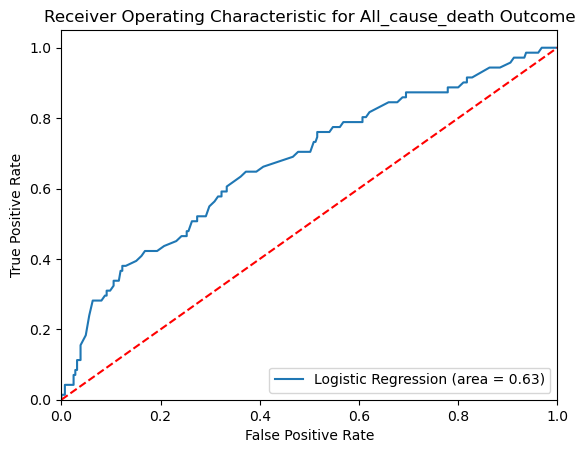

outcome:  Nonfatal_AMI
max accuracy:  0.6573033707865169
min accuracy:  0.550561797752809
overall accuracy:  0.6249276114940358


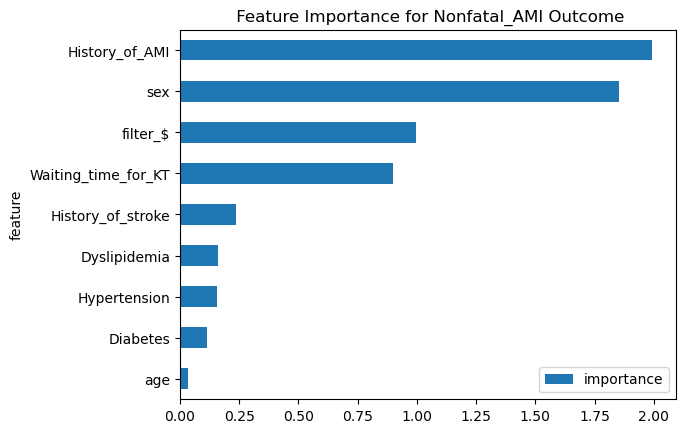

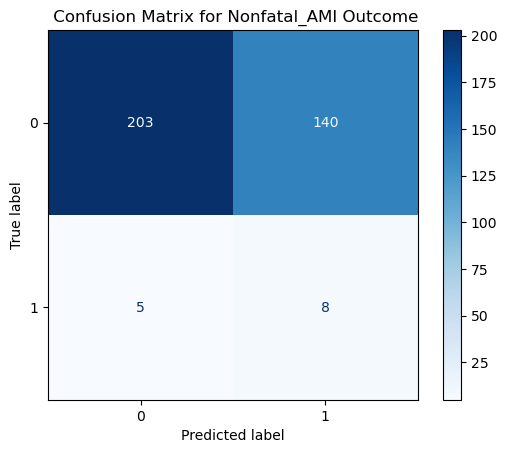

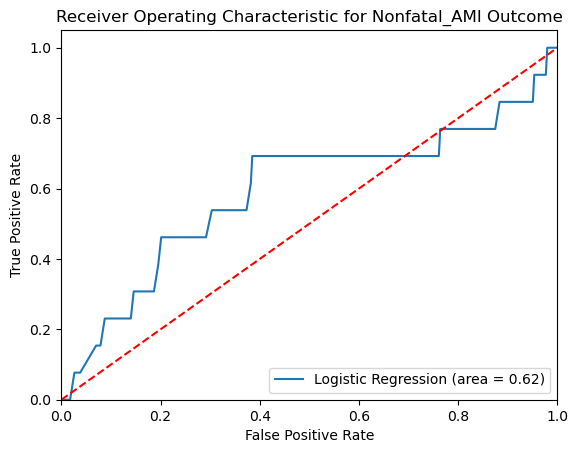

outcome:  Nonfatal_stroke
max accuracy:  0.702247191011236
min accuracy:  0.6292134831460674
overall accuracy:  0.6771511975576747


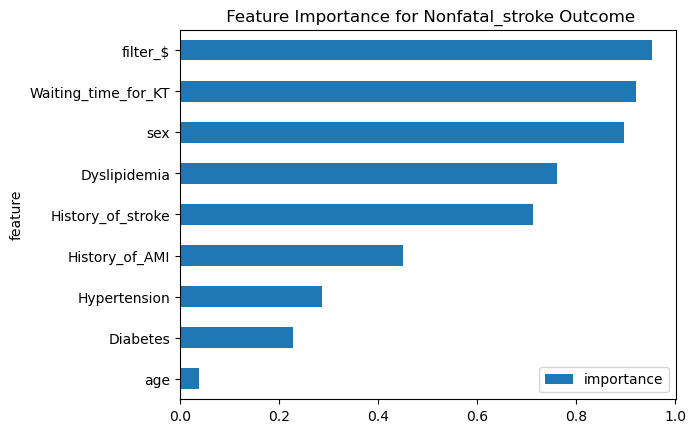

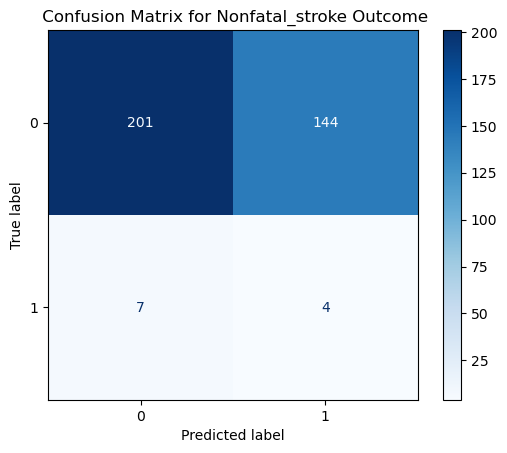

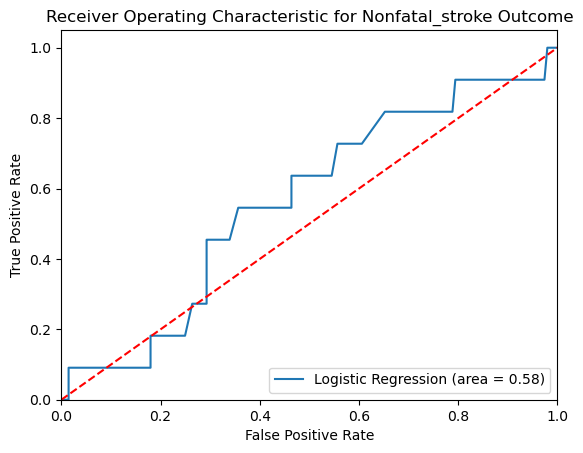

In [91]:
y_vars = ['Primary_events', 'All_cause_death', 'Nonfatal_AMI', 'Nonfatal_stroke']
y_vars_incl_time = ['Primary_events', 'All_cause_death', 'Nonfatal_AMI', 'Nonfatal_stroke',
                   'Primary_events_time', "All_cause_time", "Nonfatal_AMI_time", "Nonfatal_stroke_time"]

for y_var in y_vars:
    X = data.drop(y_vars_incl_time, axis=1, inplace=False)
    y = data.loc[:, data.columns == y_var]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores = []
    coefs = []
    model = LogisticRegression(max_iter = 10000)
    

    for train_idx, test_idx in skf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx].values.ravel()
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx].values.ravel()
        
        X_train_os, y_train_os = SMOTE().fit_resample(X_train, y_train)
        
        model.fit(X_train_os, y_train_os)
        scores.append(model.score(X_test, y_test))
        coefs.append(model.coef_)
    
    print('outcome: ', y_var)
    print("max accuracy: ", max(scores))
    print('min accuracy: ', min(scores))
    print('overall accuracy: ', np.mean(scores))
    
    # feature importance
    avg_importance = (np.mean(np.abs(coefs), axis=0)).flatten()
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': avg_importance})
    feature_importance = feature_importance.sort_values('importance', ascending=True)
    feature_importance.plot(x='feature', y='importance', kind='barh')
    plt.title(f" Feature Importance for {y_var} Outcome")
    plt.show()
    
    # confusion matrix
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f" Confusion Matrix for {y_var} Outcome")
    plt.show()
    

    # ROC curve
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {y_var} Outcome')
    plt.legend(loc="lower right")
    plt.show()

# KT Wait Time-Agnostic Logistic Regression Model 

In [92]:
no_wait_data = data.drop(['Waiting_time_for_KT', 'filter_$'], axis=1)
no_wait_data.head()

,Primary_events,Primary_events_time,sex,age,Diabetes,Hypertension,Dyslipidemia,History_of_AMI,History_of_stroke,All_cause_death,All_cause_time,Nonfatal_AMI,Nonfatal_AMI_time,Nonfatal_stroke,Nonfatal_stroke_time
0,0,2.761644,0,15,0,0,0,0,0,0,2.761644,0,2.761644,0,2.761644
1,0,6.608219,0,15,0,1,0,0,0,0,6.608219,0,6.608219,0,6.608219
2,0,5.380822,1,15,0,1,0,0,0,0,5.380822,0,5.380822,0,5.380822
3,0,2.030137,1,15,0,0,0,0,0,0,2.030137,0,2.030137,0,2.030137
4,0,12.715068,0,15,0,0,0,0,0,0,12.715068,0,12.715068,0,12.715068


outcome:  Primary_events
max accuracy:  0.6797752808988764
min accuracy:  0.5730337078651685
overall accuracy:  0.6226890756302522



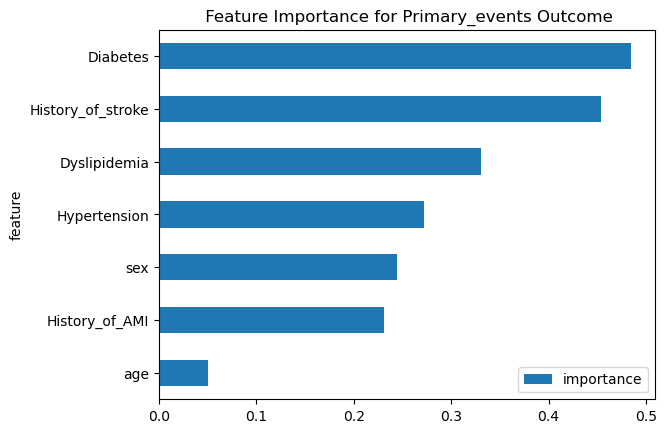

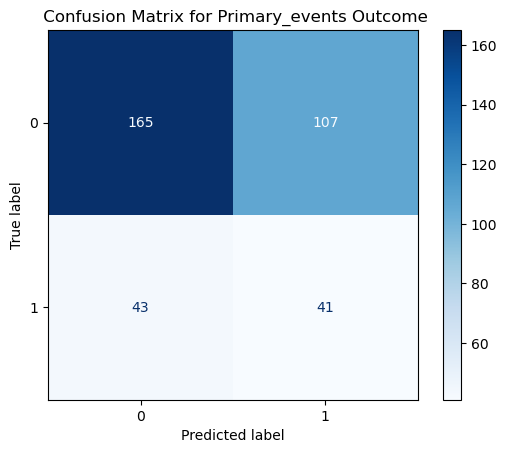

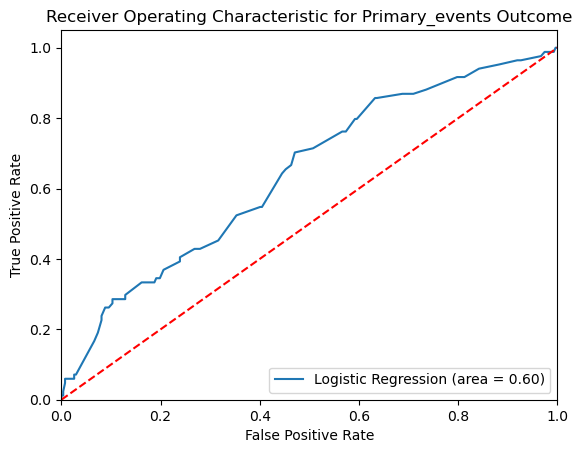

outcome:  All_cause_death
max accuracy:  0.6713483146067416
min accuracy:  0.5786516853932584
overall accuracy:  0.6319555912252541



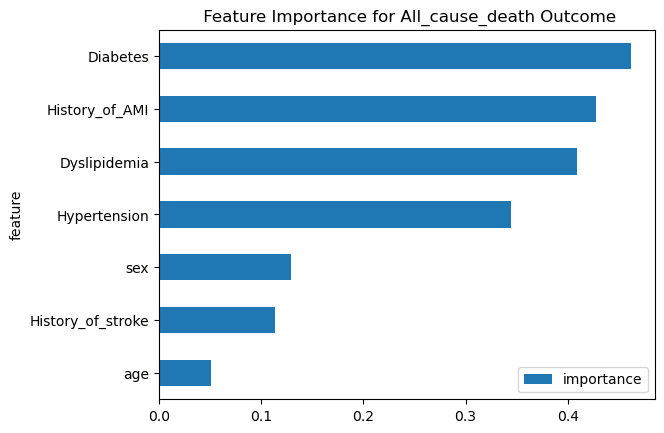

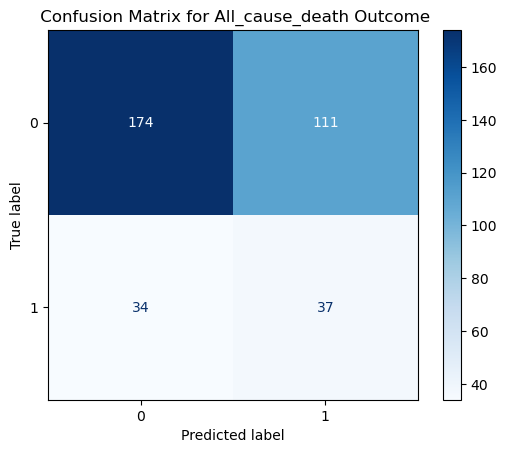

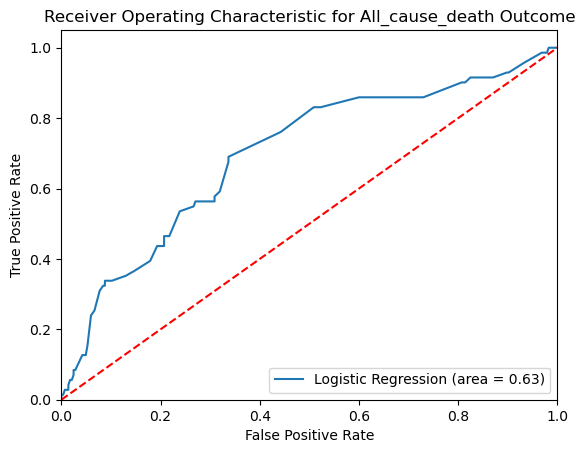

outcome:  Nonfatal_AMI
max accuracy:  0.6573033707865169
min accuracy:  0.5337078651685393
overall accuracy:  0.5715938060617505



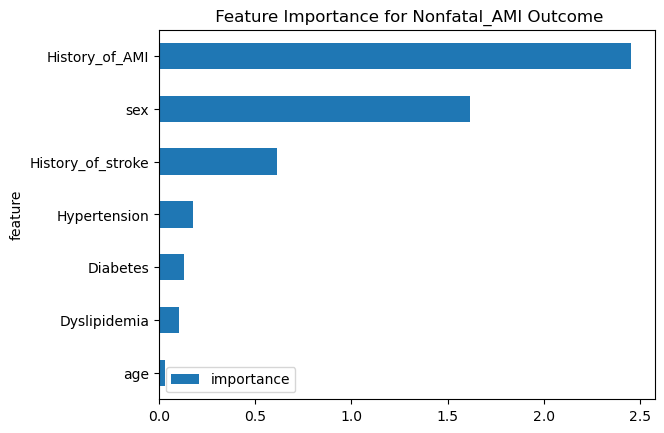

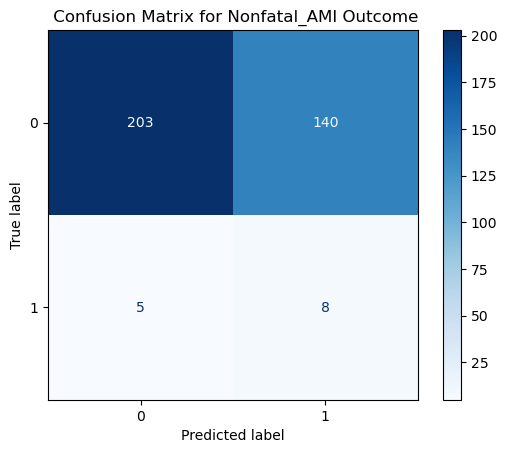

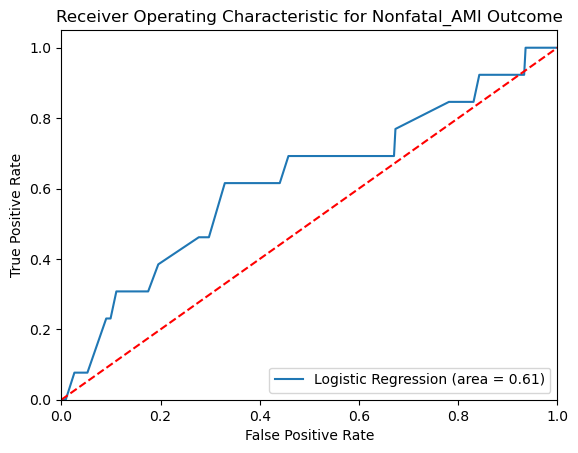

outcome:  Nonfatal_stroke
max accuracy:  0.7002801120448179
min accuracy:  0.5955056179775281
overall accuracy:  0.6583199571963616



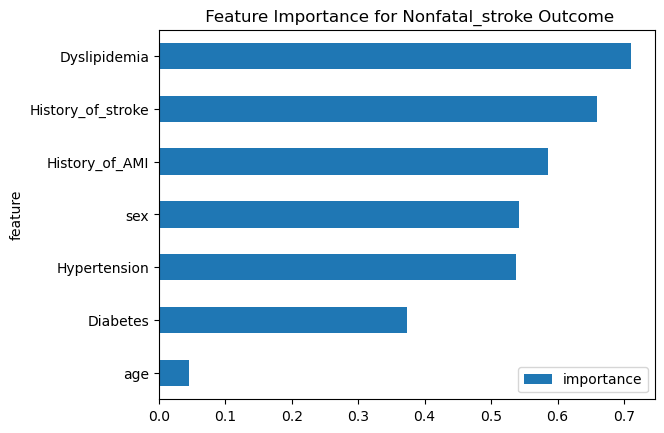

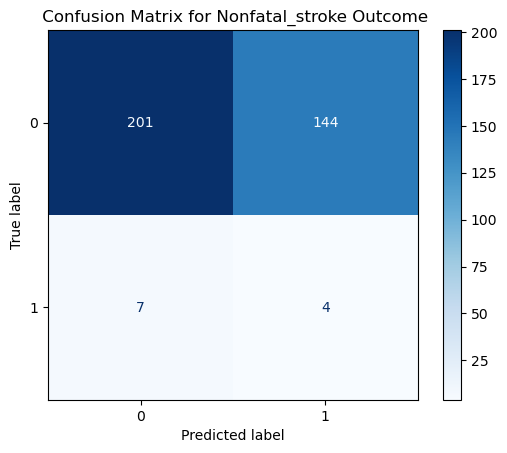

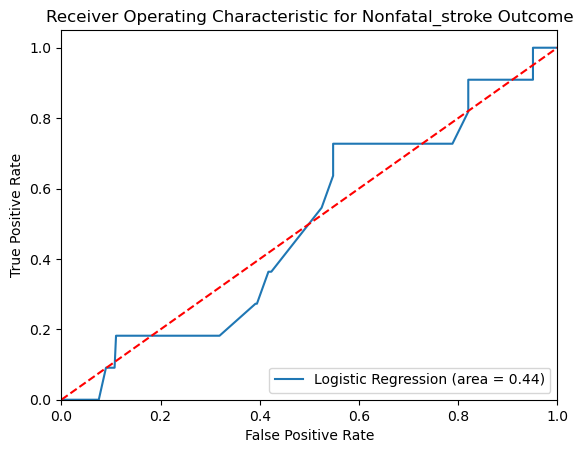

In [93]:
for y_var in y_vars:
    X = no_wait_data.drop(y_vars_incl_time, axis=1, inplace=False)
    y = no_wait_data.loc[:, no_wait_data.columns == y_var]
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores = []
    coefs = []
    model = LogisticRegression(max_iter = 10000)
    

    for train_idx, test_idx in skf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx].values.ravel()
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx].values.ravel()
        
        X_train_os, y_train_os = SMOTE().fit_resample(X_train, y_train)
        
        model.fit(X_train_os, y_train_os)
        scores.append(model.score(X_test, y_test))
        coefs.append(model.coef_)
    
    print('outcome: ', y_var)
    print("max accuracy: ", max(scores))
    print('min accuracy: ', min(scores))
    print('overall accuracy: ', np.mean(scores), end='\n\n')
    
    # feature importance
    avg_importance = (np.mean(np.abs(coefs), axis=0)).flatten()
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': avg_importance})
    feature_importance = feature_importance.sort_values('importance', ascending=True)
    feature_importance.plot(x='feature', y='importance', kind='barh')
    plt.title(f" Feature Importance for {y_var} Outcome")
    plt.show()
    
    # confusion matrix
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f" Confusion Matrix for {y_var} Outcome")
    plt.show()
    

    # ROC curve
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {y_var} Outcome')
    plt.legend(loc="lower right")
    plt.show()